# Computer Vision CSCI-GA.2272-001 Assignment 1, part 1.

Fall 2021 semester.

Due date: **September 30th 2021.**

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch by modifying this ipython notebook (File-->Save a copy...).

To install PyTorch, follow instructions at http://pytorch.org/

Please submit your assignment by uploading this iPython notebook to Brightspace.

## Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

## Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 1 epoch (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.
(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Training a Multi-Layer Network on MNIST [10%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.
-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

## Training a Convolutional Network on CIFAR [25%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist). Also, you may find training is faster if you use a GPU runtime (RunTime-->Change Runtime Type-->GPU). 

- Give a breakdown of the parameters within the above model, and the overall number.

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(3,3))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

<Figure size 216x216 with 0 Axes>

In [ ]:
# options
dataset = 'cifar10' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 20       # number of epochs to train
lr = 0.02        # learning rate
limit = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])


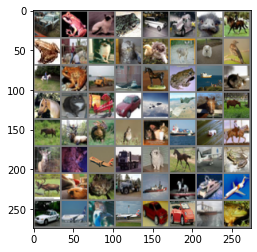

In [ ]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

# Here's where we limit the dataset.
# if limit:
#     trainset.data = trainset.data[:50]

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

# Visualize images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
imshow(utils.make_grid(images))

In [ ]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

# MNIST
# class Net(nn.Module):
#     def __init__(self, num_inputs, num_outputs):
#         super(Net, self).__init__()
#         self.linear1 = nn.Linear(num_inputs, 1000)
#         self.tanh = nn.Tanh()
#         self.linear2 = nn.Linear(1000, num_outputs)

#     def forward(self, input):
#         input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
#         output = self.linear1(input)
#         output = self.tanh(output)
#         output = self.linear2(output)
#         return output
    
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.tanh = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 128, 5)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3200, 64)
        self.linear2 = nn.Linear(64, num_outputs)

    def forward(self, input):
        # input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.conv1(input)
        output = self.tanh(output)
        output = self.pool1(output)
        output = self.conv2(output)
        output = self.tanh(output)
        output = self.pool1(output)
        output = self.flatten(output)
        output = self.linear1(output)
        output = self.tanh(output)
        output = self.linear2(output)
        return output

network = Net(num_inputs, num_outputs).to(device)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [ ]:
def train(epoch):
    network.train()
    count = 0
    for i in range(epoch):
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = Variable(data).to(device), Variable(target).to(device)
          optimizer.zero_grad()
          output = network(data)
          loss = F.cross_entropy(output, target)
          loss.backward()
          optimizer.step()
          if batch_idx % 100 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  i, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.item()))
          count += 1
          if limit and count == 50:
            break

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [ ]:
train(epochs)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.302511
Train Epoch: 0 [6400/50000 (13%)]	Loss: 1.979023
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.957969
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.996101
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.692209
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.745138
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.554038
Train Epoch: 0 [44800/50000 (90%)]	Loss: 1.593677
Train Epoch: 1 [0/50000 (0%)]	Loss: 1.585230
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.516345
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.592007
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.382341
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.589482
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.388776
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.647048
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.475697
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.584579
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.389371
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.395314
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.150158
Train Epoch: 2 [25

In [ ]:
test()


Test set: Average loss: 0.9651, Accuracy: 6754/10000 (68%)



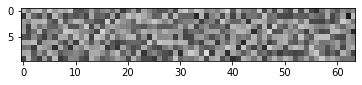

In [ ]:
image = network.linear2.weight
imshow(utils.make_grid(image.cpu()))



# Training a Single Layer Network on MNIST [10%]
(a) 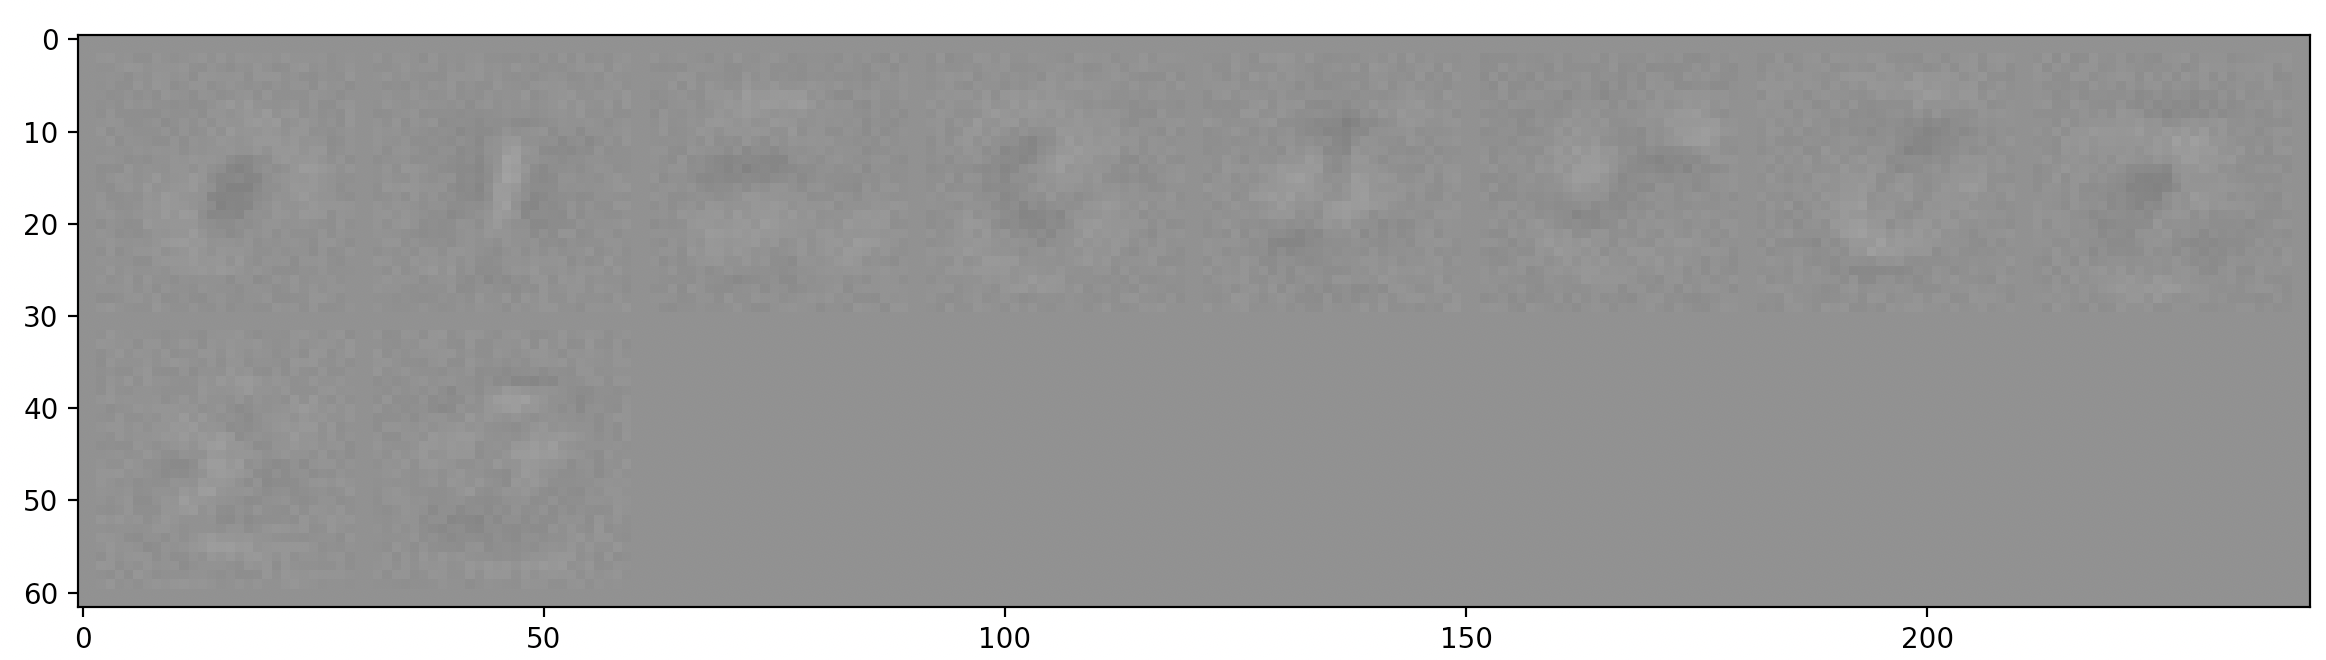

(b) 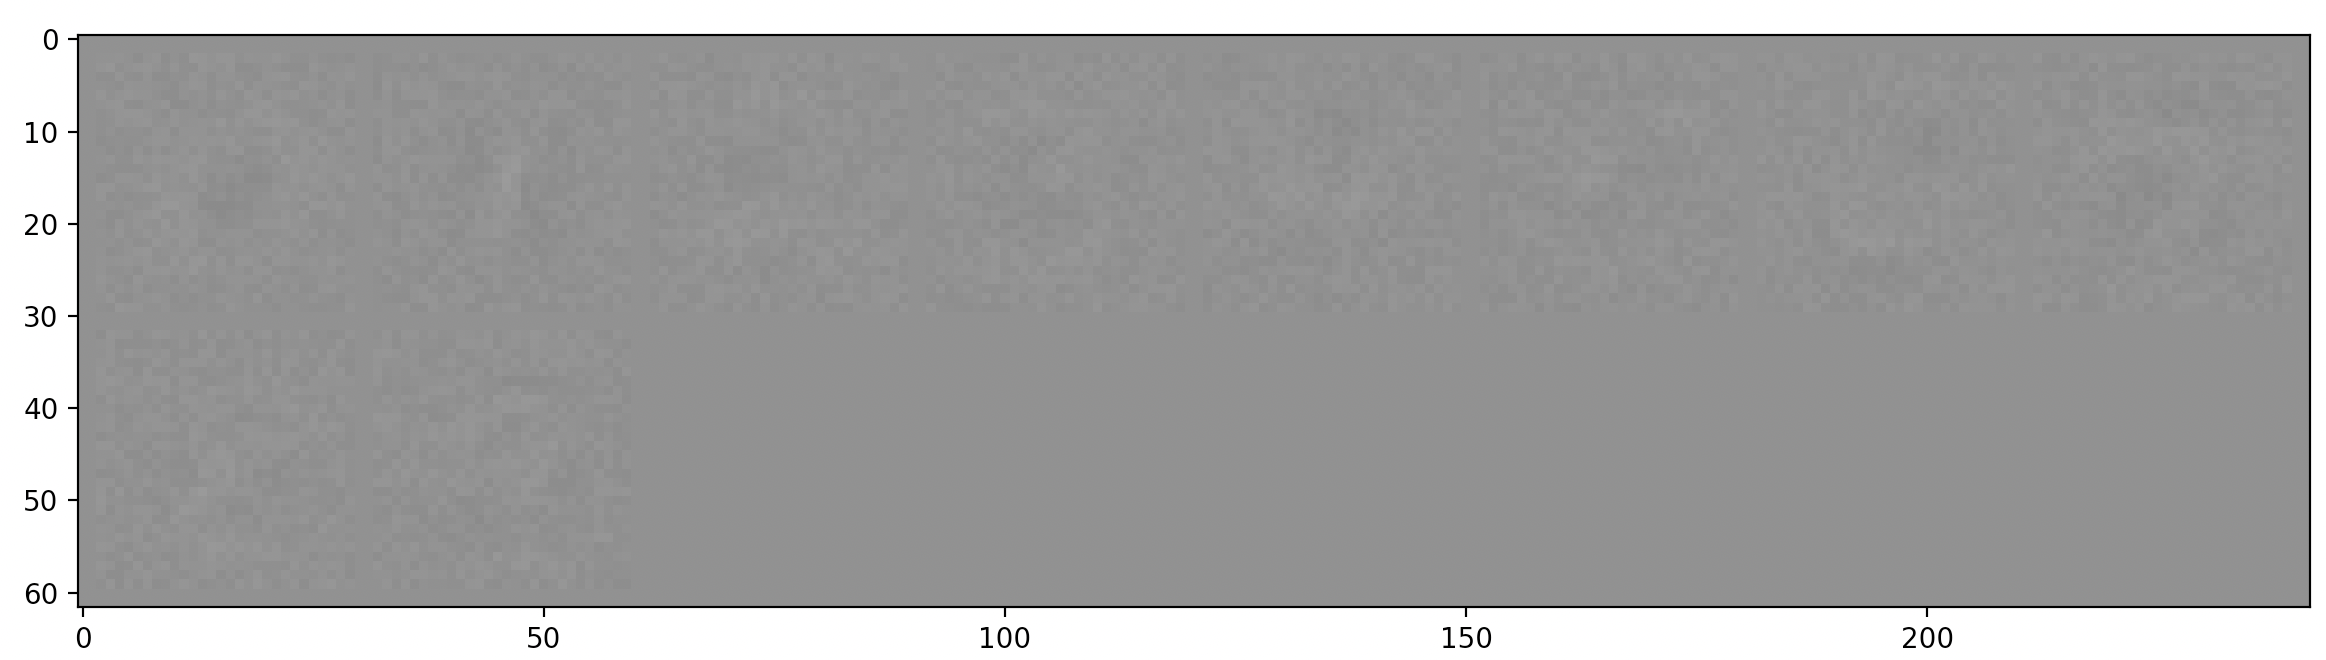

With the reduction in the number of training examples, we can see the weight visualization reduce in terms of it's clarity as there's not enough data to fit the weights close enough to the desired output.